In [6]:
pwd

'/media/student1/NewVolume/MR_Reconstruction/code/fastmri'

In [7]:
import glob
import h5py
import torch
from matplotlib import pyplot as plt
import numpy as np
import os

In [8]:
from data import transforms as T

In [70]:
def c3_multiplier_npy(shape=(320,320)):
    shp = (shape[0],shape[1])

    mul_mat=np.resize([1,-1],shp)
    
    return mul_mat * mul_mat.T


def c3_torch(shp): 
    c3m = c3_multiplier_npy(shp)
    return torch.from_numpy(np.dstack((c3m,c3m))).float()

In [83]:
# torch fft requires (bat, w,h, 2)

ifft_c3 = lambda kspc3: torch.ifft(T.ifftshift(kspc3,dim=(-3,-2)),2,normalized=True)

fft_c3 = lambda im: T.fftshift(torch.fft(im,2,normalized=True),dim=(-3,-2))

In [84]:
shp = (360,360)
# shp = (320,320)

In [85]:
c3m = c3_torch(shp)

In [86]:
def tosquare(ksp,shp):
    rec = T.ifft2(ksp)
    return c3m * T.fft2(T.complex_center_crop(rec,shp)) * 100000

In [143]:
# ksp = None

datadir = '../../datasets/fastmri/multicoil_train/'
outdir = datadir+'/../multicoil_train2/'


for fi in glob.glob(datadir+'/*.h5'):
    with h5py.File(fi,'r') as h5:
        print(fi)
        volume_ksp = h5['kspace']
        print(volume_ksp.shape,volume_ksp.dtype)
        nslice,nch, ht, wd = volume_ksp.shape
        

        for sl in range(2,nslice-2):
            ksp = T.to_tensor(volume_ksp[sl])
            sq = tosquare(ksp,shp)
            
            with h5py.File('%s/%s-%.2d.h5' % (outdir,os.path.basename(fi)[:-3],sl),'w') as hw:
                hw['kspace']=sq.numpy()
        break        

../../datasets/fastmri/multicoil_train/file1001916.h5
(35, 15, 640, 372) complex64


In [148]:
to_cplx = lambda tor,ch: tor[ch,:,:,0].numpy()+1j*tor[ch,:,:,1].numpy()
sumsq = lambda tor: torch.sum(tor**2,dim=(0,-1))

plotksp = lambda ksp: plt.imshow(np.log(1e-2+np.abs(ksp)))
plotim = lambda im,rfunc: plt.imshow(rfunc(im),cmap='gray')
nop = lambda x: x

In [149]:
def plotch(ksp,ch):
    plt.subplot(1,3,1)
    plotksp(to_cplx(ksp,ch)*100000)
    plt.colorbar()
    if ksp.shape[-3]!=ksp.shape[-2]:
        im = T.ifft2(ksp)
    else:
        im = ifft_c3(ksp)
        
    plt.subplot(1,3,2)
    plotim(to_cplx(im,ch),np.abs)
    plt.colorbar()
    
    plt.subplot(1,3,3)
    plotim(torch.sqrt(sumsq(im)),np.abs)
#     plotim(T.root_sum_of_squares(T.complex_abs(im)),nop)
    plt.colorbar()

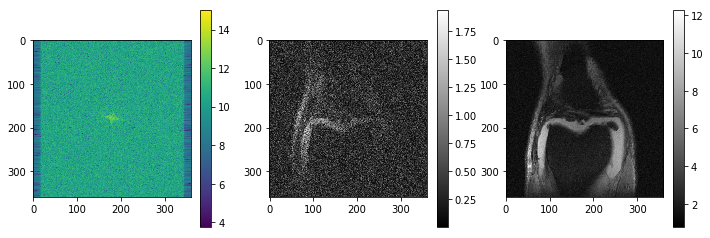

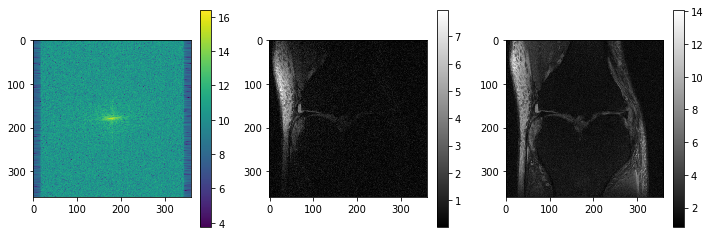

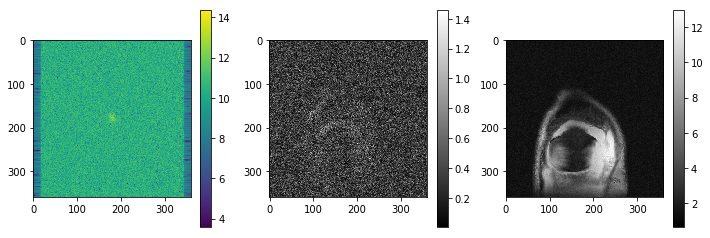

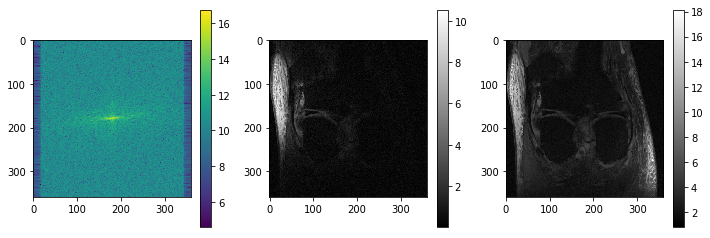

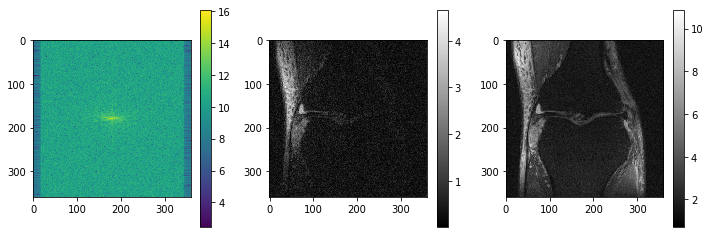

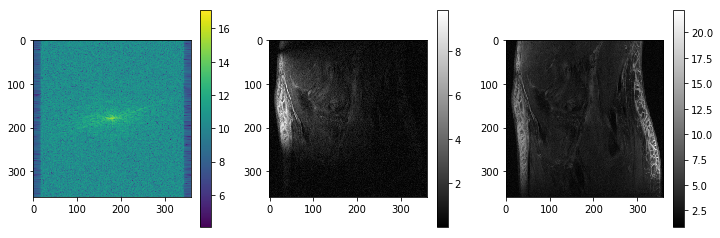

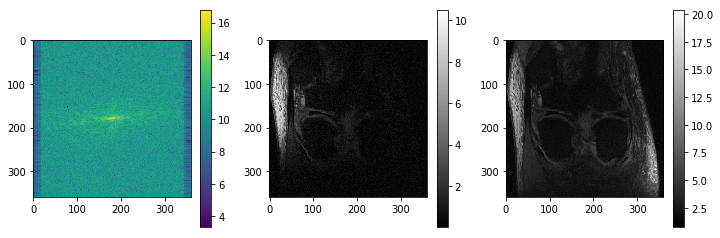

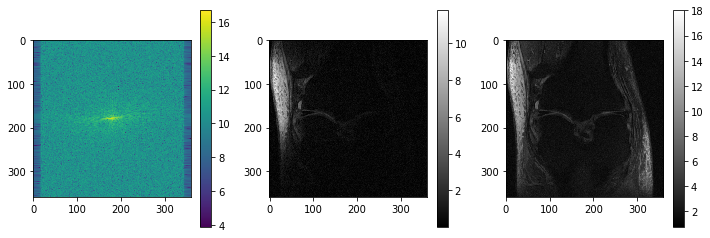

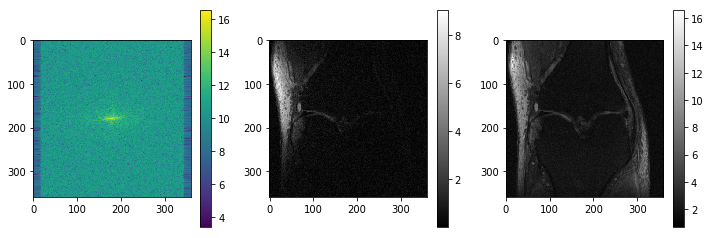

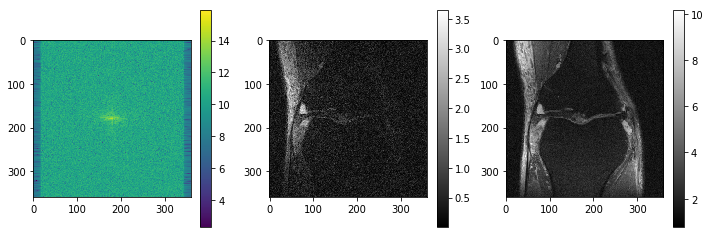

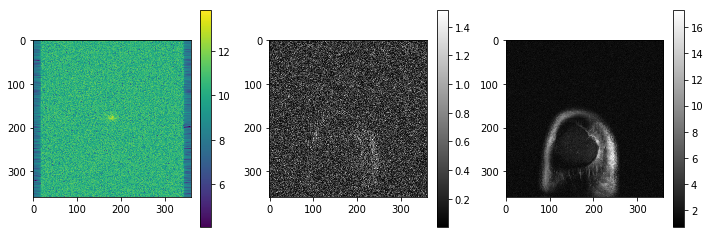

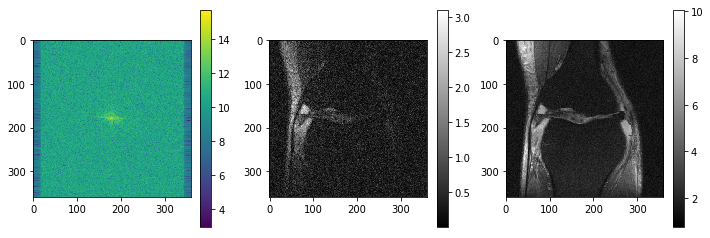

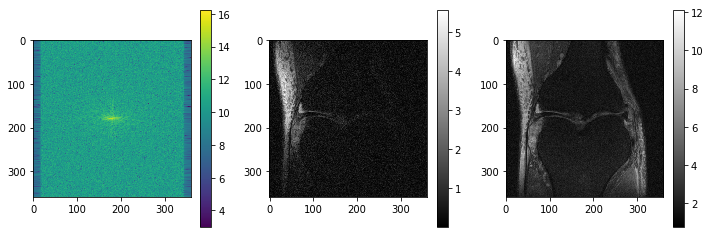

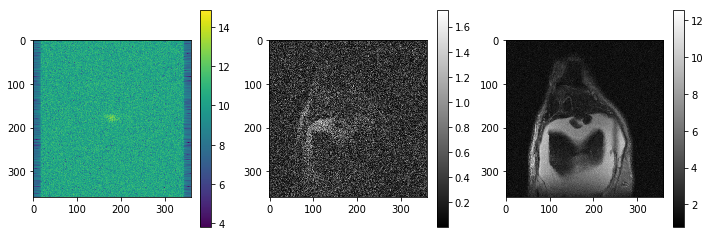

In [ ]:
slices = glob.glob(outdir+'/*.h5')

# selslice = len(slices)//3
# ksp = None

for selslice in range(len(slices)):

    with h5py.File(slices[selslice],'r') as h5:
        ksp = torch.from_numpy(h5['kspace'][()])
        plt.figure(figsize=(12,4))
        plotch(ksp,9)